In [3]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [4]:
# library calling dataset
import pandas as pd
import numpy as np 

# library visualization
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from PIL import Image
import glob, cv2, os
import pathlib

# library preprocessing data
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping ,LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# library model definition and training algoritma
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers.legacy import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
# library model evaluation
from sklearn.metrics import classification_report , confusion_matrix
import warnings



In [5]:
# Define the path to your dataset directory
dataset_dir = './fruit_dataset'

# Create an ImageDataGenerator with normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to be between 0 and 1
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
#     fill_mode='nearest',
    validation_split=0.2,  # Split the dataset into 80% training and 20% validation
)

# Create training dataset
train_dataset = image_generator.flow_from_directory(
    dataset_dir,
    batch_size=15,  # Adjust the batch size as needed
    class_mode='categorical',  # Use 'binary' for binary classification
    subset='training'  # Specify this is the training set
)

# Create validation dataset
validation_dataset = image_generator.flow_from_directory(
    dataset_dir,
    batch_size=15,
    class_mode='categorical',
    subset='validation'  # Specify this is the validation set
)

# Define the path to your test set directory
test_dir = './test_dataset'

# Create an ImageDataGenerator with normalization (if needed)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create a test dataset generator
test_data = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Adjust the target size to match your model's input size
    batch_size=10,  # Adjust the batch size as needed
    class_mode='categorical',  # Use 'binary' for binary classification
    shuffle=False  # Do not shuffle for confusion matrix
)

Found 4320 images belonging to 6 classes.
Found 1080 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [7]:
print(test_data.class_indices)


{'Apple': 0, 'Banana': 1, 'Guava': 2, 'Lime': 3, 'Orange': 4, 'Pomegranate': 5}


In [8]:
# index label class train data
labelindex = train_dataset.class_indices
labelindex

{'Apple': 0, 'Banana': 1, 'Guava': 2, 'Lime': 3, 'Orange': 4, 'Pomegranate': 5}

In [9]:
# CNN Initialization
model = tf.keras.models.Sequential()

# configuration layer 1
model.add(Conv2D(32, 11, padding = 'same', activation=tf.keras.layers.LeakyReLU(),input_shape=(256,256,3))) # number of features/adjust the data, if the color image is added the number 3
model.add(BatchNormalization())
model.add(MaxPool2D(2)) # Maxpool with 2x2 matrix

#configuration layer 2
model.add(Conv2D(64, 5, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

# configuration layer 3
model.add(Conv2D(128, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

# configuration layer 4
model.add(Conv2D(64, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(2))

# # configuration layer 5
# model.add(Conv2D(128, 3, padding = 'same', activation=tf.keras.layers.LeakyReLU(alpha = 0.005)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(5))

# flattend
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu',kernel_regularizer=l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu',kernel_regularizer=l2(0.05)))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax')) 

In [10]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [12]:
# callback at 100% accuracy
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True)]

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.1
    return lr

# model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# lr_scheduler = LearningRateScheduler(lr_schedule)
# model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001,rho=0.5,epsilon=0.005), metrics=['accuracy'])

# # model compile
model.compile(loss="categorical_crossentropy",
              optimizer=SGD(learning_rate= 0.00001,momentum=0.5),metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      11648     
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                        

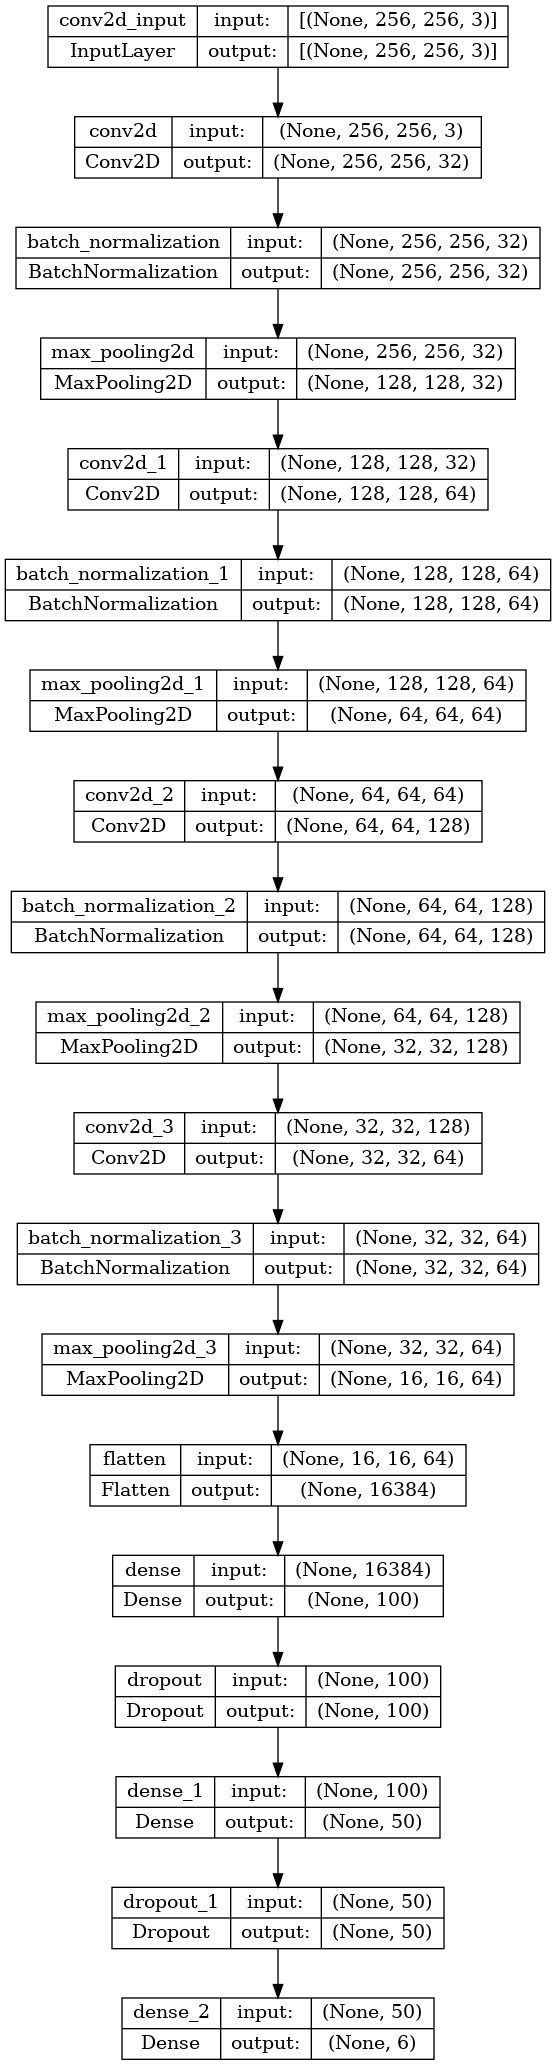

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
# Set up ModelCheckpoint callback
checkpoint_filepath = './models/Jan1_sgd_fruit_4layers.h5'
checkpoint = ModelCheckpoint(checkpoint_filepath, 
                             monitor='val_accuracy',  # Monitor validation accuracy
                             save_best_only=True,     # Save only the best models
                             mode='max',              # Save when the monitored metric is at its maximum
                             verbose=1)


In [17]:
# training model

%time

project = model.fit(train_dataset, epochs = 50, verbose=1, validation_data = validation_dataset,callbacks=[checkpoint])

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.11 µs
Epoch 1/50
288/288 [==============================] - ETA: 0s - loss: 15.7290 - accuracy: 0.1981
Epoch 1: val_accuracy improved from -inf to 0.16759, saving model to ./savedModel/best_model_Dec29_sgd_fruit_4layers.h5
288/288 [==============================] - 43s 143ms/step - loss: 15.7290 - accuracy: 0.1981 - val_loss: 15.1849 - val_accuracy: 0.1676
Epoch 2/50
288/288 [==============================] - ETA: 0s - loss: 15.2087 - accuracy: 0.2641
Epoch 2: val_accuracy improved from 0.16759 to 0.25093, saving model to ./savedModel/best_model_Dec29_sgd_fruit_4layers.h5
288/288 [==============================] - 41s 143ms/step - loss: 15.2087 - accuracy: 0.2641 - val_loss: 15.0014 - val_accuracy: 0.2509
Epoch 3/50
288/288 [==============================] - ETA: 0s - loss: 14.9802 - accuracy: 0.3169
Epoch 3: val_accuracy improved from 0.25093 to 0.44259, saving model to ./savedModel/best_model_Dec29_sgd_fruit_4layers.h5
288/288

Epoch 26/50
288/288 [==============================] - ETA: 0s - loss: 13.8312 - accuracy: 0.6514
Epoch 26: val_accuracy improved from 0.66296 to 0.66389, saving model to ./savedModel/best_model_Dec29_sgd_fruit_4layers.h5
288/288 [==============================] - 41s 144ms/step - loss: 13.8312 - accuracy: 0.6514 - val_loss: 13.8522 - val_accuracy: 0.6639
Epoch 27/50
288/288 [==============================] - ETA: 0s - loss: 13.7870 - accuracy: 0.6569
Epoch 27: val_accuracy did not improve from 0.66389
288/288 [==============================] - 41s 144ms/step - loss: 13.7870 - accuracy: 0.6569 - val_loss: 13.8326 - val_accuracy: 0.6630
Epoch 28/50
288/288 [==============================] - ETA: 0s - loss: 13.7463 - accuracy: 0.6762
Epoch 28: val_accuracy did not improve from 0.66389
288/288 [==============================] - 41s 143ms/step - loss: 13.7463 - accuracy: 0.6762 - val_loss: 13.8110 - val_accuracy: 0.6537
Epoch 29/50
288/288 [==============================] - ETA: 0s - loss:

In [19]:
model = tf.keras.models.load_model('./models/Jan1_sgd_fruit_4layers.h5')

# Evaluate the model on the validation data
evaluation = model.evaluate(test_data)

# Extract accuracy from the evaluation result
accuracy = evaluation[1]
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

60/60 [==============================] - 1s 10ms/step - loss: 12.8771 - accuracy: 0.9133
Validation Accuracy: 91.33%


In [20]:
history = project.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

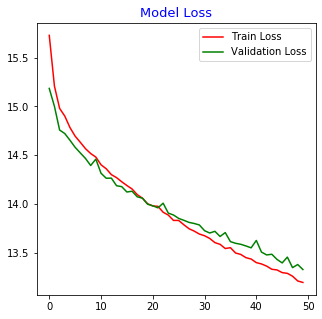

In [21]:
plt.figure(figsize=(5,5))
plt.plot(history["loss"],label = "Train Loss", color = "red")
plt.plot(history["val_loss"],label = "Validation Loss",color = "green")
plt.title("Model Loss", color = "blue", size = 13)
plt.legend()
plt.show()

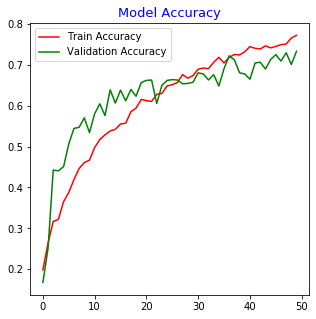

In [22]:
plt.figure(figsize=(5,5))
plt.plot(history["accuracy"],label = "Train Accuracy", color = "red")
plt.plot(history["val_accuracy"],label = "Validation Accuracy", color = "green")
plt.title("Model Accuracy", color = "blue", size = 13)
plt.legend()
plt.show()

60/60 [==============================] - 1s 10ms/step


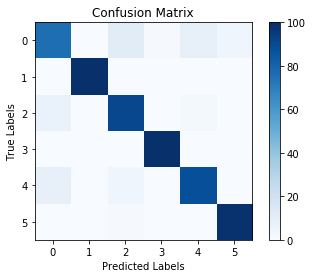

              precision    recall  f1-score   support

       Apple       0.84      0.76      0.80       100
      Banana       1.00      1.00      1.00       100
       Guava       0.85      0.91      0.88       100
        Lime       0.99      1.00      1.00       100
      Orange       0.90      0.88      0.89       100
 Pomegranate       0.96      0.99      0.98       100

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



In [23]:
model = tf.keras.models.load_model('./models/Jan1_sgd_fruit_4layers.h5')

# Make predictions on the test set
y_pred = model.predict(test_data)

# Convert the one-hot encoded labels to class labels
y_true = test_data.classes
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_names = list(test_data.class_indices.keys())
# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [24]:
# model evaluation
score = model.evaluate(test_data)
print('test loss:', score[0])
print('test accuracy:', score[1])

60/60 [==============================] - 1s 9ms/step - loss: 12.5841 - accuracy: 0.9233
test loss: 12.584102630615234
test accuracy: 0.9233333468437195


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model

# Assuming you have a CNN model named model

# Function to extract features using the intermediate layers of the CNN model
def extract_features(model, input_data):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
    features = intermediate_layer_model.predict(input_data)
    return features

# Assuming X contains your images and y contains the fruit labels
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming you have already loaded your model
model = tf.keras.models.load_model('./models/Jan1_sgd_fruit_4layers.h5')

# Extract features from the CNN model
X_train_features = extract_features(model, train_dataset)
X_test_features = extract_features(model, test_data)

# Create a Decision Tree classifier
ripeness_model = DecisionTreeClassifier()

# Train the model
ripeness_model.fit(X_train_features.reshape(X_train_features.shape[0],-1), train_dataset.labels)

# Make predictions on the test set features
predictions = ripeness_model.predict(X_test_features.reshape(X_test_features.shape[0],-1))

# Evaluate the model
accuracy = accuracy_score(test_data.labels, predictions)
print(f"Accuracy: {accuracy}")


60/60 [==============================] - 1s 9ms/step


In [37]:
X_test_features.reshape(X_test_features.shape[0],-1).shape

(1000, 18432)

In [38]:
X_test_features.shape

(1000, 12, 12, 128)

In [19]:
import os
import shutil
import random

def move_random_images(source_folder, destination_folder, num_images_to_move=100):
    # Get a list of all image files in the source folder
    all_images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg'))]

    # Ensure that the number of images to move does not exceed the total number of available images
    num_images_to_move = min(num_images_to_move, len(all_images))

    # Randomly select num_images_to_move images
    selected_images = random.sample(all_images, num_images_to_move)

    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Move selected images to the destination folder
    for image_filename in selected_images:
        source_path = os.path.join(source_folder, image_filename)
        destination_path = os.path.join(destination_folder, image_filename)
        shutil.move(source_path, destination_path)
        print(f"Moving {image_filename} to {destination_folder}")

# Replace these paths with your actual source and destination folder paths
source_folder_path = './fruit_dataset/Apple'
destination_folder_path = './test_set/Apple_Good'

# Call the function to move 45 random images
move_random_images(source_folder_path, destination_folder_path, num_images_to_move=100)


Moving IMG_9419.jpg to ./test_set/Apple_Good
Moving 20190809_165458.jpg to ./test_set/Apple_Good
Moving 20190812_182524.jpg to ./test_set/Apple_Good
Moving 20190809_161106.jpg to ./test_set/Apple_Good
Moving 20190809_121016.jpg to ./test_set/Apple_Good
Moving 20190809_120605.jpg to ./test_set/Apple_Good
Moving 20190809_155927.jpg to ./test_set/Apple_Good
Moving 20190809_121931.jpg to ./test_set/Apple_Good
Moving 20190809_120304.jpg to ./test_set/Apple_Good
Moving 20190812_183301.jpg to ./test_set/Apple_Good
Moving 20190809_161118.jpg to ./test_set/Apple_Good
Moving IMG_9560.jpg to ./test_set/Apple_Good
Moving 20190812_183424.jpg to ./test_set/Apple_Good
Moving 20190812_185103.jpg to ./test_set/Apple_Good
Moving IMG_9602.jpg to ./test_set/Apple_Good
Moving 20190812_185252.jpg to ./test_set/Apple_Good
Moving IMG_9537.jpg to ./test_set/Apple_Good
Moving IMG_9624.jpg to ./test_set/Apple_Good
Moving IMG_9577.jpg to ./test_set/Apple_Good
Moving IMG_9423.jpg to ./test_set/Apple_Good
Moving 20

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('./models/Jan1_sgd_fruit_4layers.h5')

# Load a single image for prediction
img_path = './test_set/bad_orange.jpg'
img = image.load_img(img_path, target_size=(256, 256))

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# Expand the dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Normalize the pixel values to be between 0 and 1
img_array /= 255.0

# Make predictions
predictions = model.predict(img_array)

print("Raw Predictions:", np.argmax(predictions))


1/1 [==============================] - 0s 79ms/step
Raw Predictions: [[3.1818037e-03 2.4527704e-04 8.8220392e-04 1.6457169e-01 1.3464107e-03
  1.1784778e-03 7.0106201e-03 7.9332894e-01 2.0624060e-02 7.6305009e-03]]
